In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from tqdm import tqdm
import xgboost as xgb
import cvxpy as cp
from optuna.integration import OptunaSearchCV
from optuna.distributions import FloatDistribution, IntDistribution, CategoricalDistribution

import sys
sys.path.append('../scripts')

import models
import data
import utils

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
seed = 0

In [5]:
X, Y = data.load_german()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
A_train = X_train.Sex.values
A_test = X_test.Sex.values

## Model without fairness

I'll train the model with the base parameters of XGBoost.

In [31]:
model = models.XGBoostWrapper()
model.fit(X_train, Y_train);

Performing a search with Optuna, it will perform a 5-fold cross validation and select the parameters with the best mean score. The score used is the ROC.

In [ ]:
model_search = OptunaSearchCV(
    models.XGBoostWrapper(),
    {
        "n_estimators" : IntDistribution(5, 100, step=10),
    },
    n_trials=100,
    random_state = seed,
    verbose = 0,
)
model_search.fit(X_train, Y_train);


In [34]:
utils.eval_model_train_test(
    model,
    X_train, Y_train, A_train,
    X_test, Y_test, A_test,
)

,roc,tpr,fnr,logloss,threshold,accuracy,precision,name
0,0.955124,0.923267,0.076733,0.313419,0.662721,0.909253,0.949109,train_g0
1,0.967223,0.870130,0.129870,0.330026,0.662721,0.882353,0.943662,train_g1
2,0.708293,0.715789,0.284211,0.537364,0.662721,0.687500,0.839506,test_g0
3,0.738723,0.808511,0.191489,0.553715,0.662721,0.722222,0.775510,test_g1


In [33]:
utils.eval_model_train_test(
    model_search,
    X_train, Y_train, A_train,
    X_test, Y_test, A_test,
)

,roc,tpr,fnr,logloss,threshold,accuracy,precision,name
0,0.919797,0.868812,0.131188,0.394797,0.634701,0.854093,0.923684,train_g0
1,0.927296,0.850649,0.149351,0.416501,0.634701,0.857143,0.922535,train_g1
2,0.674801,0.684211,0.315789,0.565942,0.634701,0.664062,0.833333,test_g0
3,0.760426,0.808511,0.191489,0.544815,0.634701,0.708333,0.760000,test_g1


In [69]:
parameters = {
    "n_estimators" : [5, 10, 15],
    "colsample_bytree" : [0.1, 0.25, 0.5, 0.75],
    "max_depth" : [3, 4, 5, 8, 10],
    "l2_weight" : [0.01, 0.1, 1, 10, 100,],
    "eta" : [0.1, 0.2, 0.3],
}
cv = GridSearchCV(models.XGBoostWrapper(), parameters,  scoring = "roc_auc")
cv.fit(X_train, Y_train)
idx = np.argmax(cv.cv_results_["mean_test_score"])
best_score = cv.cv_results_["mean_test_score"][idx]
best_score_std = cv.cv_results_["mean_test_score"][idx]
cv.best_params_, f"{best_score:.3f} +/- {best_score_std:.3f}"

({'colsample_bytree': 0.25,
  'eta': 0.2,
  'l2_weight': 0.01,
  'max_depth': 3,
  'n_estimators': 15},
 '0.751 +/- 0.751')

In [70]:
utils.eval_model_train_test(
    cv,
    X_train, Y_train, subgroup_train,
    X_test, Y_test, subgroup_test,
)

,roc,tpr,fnr,logloss,threshold,accuracy,precision,name
0,0.828811,0.740654,0.259346,0.472542,0.706457,0.756803,0.908309,train_g0
1,0.816743,0.684524,0.315476,0.532887,0.706457,0.725191,0.858209,train_g1
2,0.781463,0.816901,0.183099,0.525952,0.706457,0.745098,0.816901,test_g0
3,0.672727,0.545455,0.454545,0.581614,0.706457,0.604167,0.818182,test_g1


## Model with reinforcement for woman

In [33]:
parameters = cv.best_params_
parameters = dict([(k, [v]) for k, v in parameters.items()])
parameters["min_child_weight"] = [1]

In [57]:
parameters = {
    "max_depth" : [4],
    "colsample_bytree" : [0.5],
    "min_child_weight" : [1e-2],
    "n_estimators" : [20],
}

In [58]:
def logloss_grad(predt, dtrain):
    '''Compute the gradient for log loss.'''
    y = dtrain.get_label()
    predt = 1 / (1 + np.exp(-predt))
    grad = -(y - predt)
    return grad

def logloss_hessian(predt, dtrain):
    '''Compute the hessian for log loss.'''
    predt = 1 / (1 + np.exp(-predt))
    hess = (predt * (1 - predt))
    return hess

In [59]:
def logloss_grad_unpr(predt, dtrain, subgroup):
    '''Compute the gradient for log loss.'''
    y = dtrain.get_label()
    predt = 1 / (1 + np.exp(-predt))
    grad = -(y - predt)
    grad[subgroup == 0] = 0
    return grad

def logloss_hessian_unpr(predt, dtrain, subgroup):
    '''Compute the hessian for log loss.'''
    predt = 1 / (1 + np.exp(-predt))
    hess = (predt * (1 - predt))
    hess[subgroup == 0] = 0
    return hess

In [60]:
def obj_penalize_group_1(subgroup_idx, fair_weight):
    def custom_obj(predt, dtrain):
        subgroup = (dtrain.get_data()[:, subgroup_idx]).toarray().reshape(-1)
        weight_1 = 1 #/ len(subgroup)
        weight_2 = fair_weight #/ subgroup.sum()
        #sum_weights = (weight_1 + weight_2)
        #weight_1 /= sum_weights
        #weight_2 /= sum_weights
        grad = weight_1 * logloss_grad(predt, dtrain) + weight_2 * logloss_grad_unpr(predt, dtrain, subgroup)
        hess = weight_1 * logloss_hessian(predt, dtrain) + weight_2 * logloss_hessian_unpr(predt, dtrain, subgroup)
        return grad, hess
    return custom_obj

In [110]:
def eval_model_folds(model, X_train, Y_train):
    results = []
    for idx_train, idx_val in KFold(5, shuffle = True, random_state = 1).split(X_train.index):
        X_train_ = X_train.iloc[idx_train, :]
        X_val = X_train.iloc[idx_val, :]
        Y_train_ = Y_train.iloc[idx_train]
        Y_val = Y_train.iloc[idx_val]
        model.fit(X_train_, Y_train_)
        results.append(
            utils.eval_model_train_test(
            model,
            X_train_, Y_train_, X_train_.Sex.values,
            X_val, Y_val, X_val.Sex.values,
            )
        )
    results = pd.concat(results)
    results_mean = results.groupby(results.name).mean()
    results_std = results.groupby(results.name).std()
    return results_mean, results_std


In [116]:
model = models.XGBoostWrapper(
        objective = obj_penalize_group_1(0, 1e-3),
        n_estimators = 20,
        colsample_bytree = 0.5,
        max_depth = 4,
        min_child_weight = 1e-2,
    )
m, s = eval_model_folds(model, X_train, Y_train)
m

,roc,tpr,fnr,logloss,threshold,accuracy,precision
name,,,,,,,
test_g0,0.761441,0.791393,0.208607,0.512218,0.656981,0.730707,0.827058
test_g1,0.742297,0.784475,0.215525,0.578782,0.656981,0.710838,0.780798
train_g0,0.940907,0.911769,0.088231,0.324033,0.656981,0.895394,0.942612
train_g1,0.955777,0.867536,0.132464,0.343495,0.656981,0.879841,0.941184


In [117]:
model = models.XGBoostWrapper(
        objective = obj_penalize_group_1(0, 1e3),
        n_estimators = 20,
        colsample_bytree = 0.5,
        max_depth = 4,
        min_child_weight = 1e-2,
    )
m, s = eval_model_folds(model, X_train, Y_train)
m

,roc,tpr,fnr,logloss,threshold,accuracy,precision
name,,,,,,,
test_g0,0.697579,0.751449,0.248551,0.604301,0.571031,0.695566,0.813287
test_g1,0.674800,0.722983,0.277017,0.683306,0.571031,0.666485,0.752304
train_g0,0.742284,0.778504,0.221496,0.546227,0.571031,0.727847,0.837244
train_g1,0.999491,0.992625,0.007375,0.166008,0.571031,0.990515,0.992686


In [118]:
s

,roc,tpr,fnr,logloss,threshold,accuracy,precision
name,,,,,,,
test_g0,0.059644,0.057898,0.057898,0.095752,0.035015,0.061367,0.060279
test_g1,0.048794,0.112487,0.112487,0.106748,0.035015,0.054937,0.053392
train_g0,0.012843,0.044857,0.044857,0.034441,0.035015,0.015874,0.018346
train_g1,0.000518,0.005200,0.005200,0.014820,0.035015,0.005690,0.008813


In [65]:
lambda_values = np.append([0],np.logspace(-3, 3, num=20))
results = []
for lambda_value in tqdm(lambda_values):
    model = models.XGBoostWrapper(
        objective = obj_penalize_group_1(0, lambda_value),
        n_estimators = 20,
        colsample_bytree = 0.5,
        max_depth = 4,
        min_child_weight = 1e-2,
    )
    model.fit(X_train, Y_train)
    results_df = utils.eval_model_train_test(
        model,
        X_train, Y_train, subgroup_train,
        X_test, Y_test, subgroup_test,
    )
    results_df["lambda"] = lambda_value
    results.append(results_df)
results = pd.concat(results)

100%|██████████| 21/21 [00:01<00:00, 12.48it/s]


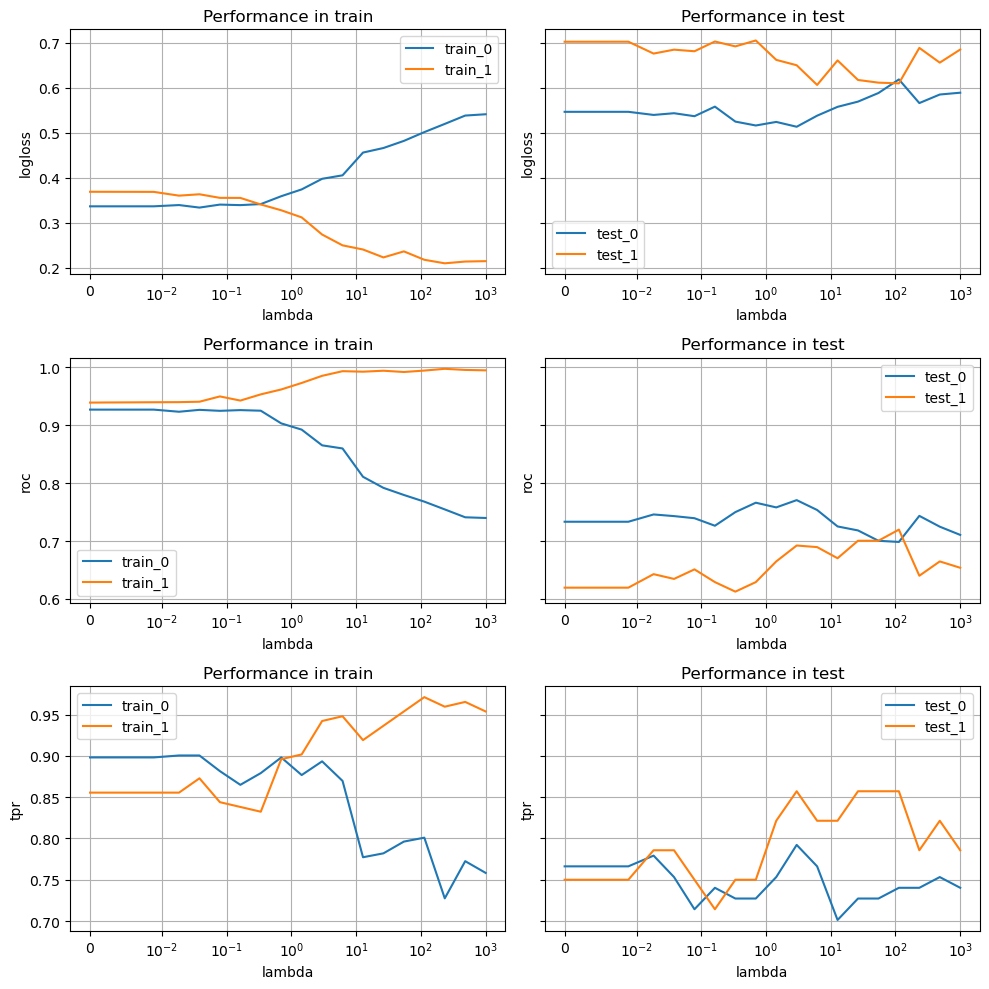

In [66]:
utils.comparison_subgrous_metrics_lambda(results)

## Model with dual step

In [49]:
def logloss_group(predt, dtrain, subgroup):
    y = dtrain.get_label()
    predt = 1 / (1 + np.exp(-predt))
    loss = - (y * np.log(predt) + (1 - y) * np.log(1 - predt))
    groups = np.unique(subgroup)
    loss_matrix = np.zeros((len(y), len(groups)))

    for i, group in enumerate(groups):
        loss_matrix[:, i] = loss # copy the column
        loss_matrix[subgroup!= group, i] = 0 # and set 0 for other groups

    loss_matrix = np.sum(loss_matrix, axis = 0)  / np.sum(loss_matrix != 0, axis = 0)
    return loss_matrix


def logloss_grad_group(predt, dtrain, subgroup):
    '''Compute the gradient for log loss for each group.'''
    y = dtrain.get_label()
    predt = 1 / (1 + np.exp(-predt))
    grad = -(y - predt)

    groups = np.unique(subgroup)
    grad_matrix = np.zeros((len(y), len(groups)))

    for i, group in enumerate(groups):
        grad_matrix[:, i] = grad # copy the column
        grad_matrix[subgroup!= group, i] = 0 # and set 0 for other groups
    return grad_matrix


def logloss_hessian_group(predt, dtrain, subgroup):
    '''Compute the hessian for log loss for each group.'''
    predt = 1 / (1 + np.exp(-predt))
    hess = (predt * (1 - predt))

    groups = np.unique(subgroup)
    hess_matrix = np.zeros((len(hess), len(groups)))

    for i, group in enumerate(groups):
        hess_matrix[:, i] = hess # copy the column
        hess_matrix[subgroup!= group, i] = 0 # and set 0 for other groups
    return hess_matrix

In [53]:
def penalize_max_loss_subgroups(subgroup_idx, fair_weight):
    weight_1 = 1 #/ (1 + fair_weight)
    weight_2 = fair_weight #/ (1 + fair_weight)
    
    def custom_obj(predt, dtrain):

        subgroup = (dtrain.get_data()[:, subgroup_idx]).toarray().reshape(-1)
        
        if weight_2 > 0:
            # dual problem
            loss_group = logloss_group(predt, dtrain, subgroup)
            mu = cp.Variable(loss_group.shape[0]) # number of groups
            z = cp.Variable(1) # z is the min of mu * loss
            constraints = [cp.sum(mu) == weight_2, mu >= 0] + [z <= mu[i] * loss_group[i] for i in range(loss_group.shape[0])]
            objective = cp.Maximize(z)
            problem = cp.Problem(objective, constraints)
            problem.solve()

            # primal problem
            mu_opt = mu.value
        else:
            mu_opt = np.zeros(len(np.unique(subgroup)))
            
        grad_group = logloss_grad_group(predt, dtrain, subgroup)
        hess_group = logloss_hessian_group(predt, dtrain, subgroup)
        grad = logloss_grad(predt, dtrain) * weight_1 + np.sum(mu_opt * grad_group, axis=1) 
        hess = logloss_hessian(predt, dtrain) * weight_1 + np.sum(mu_opt * hess_group, axis=1)

        return grad, hess
    return custom_obj

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:28<00:00,  1.14s/it]


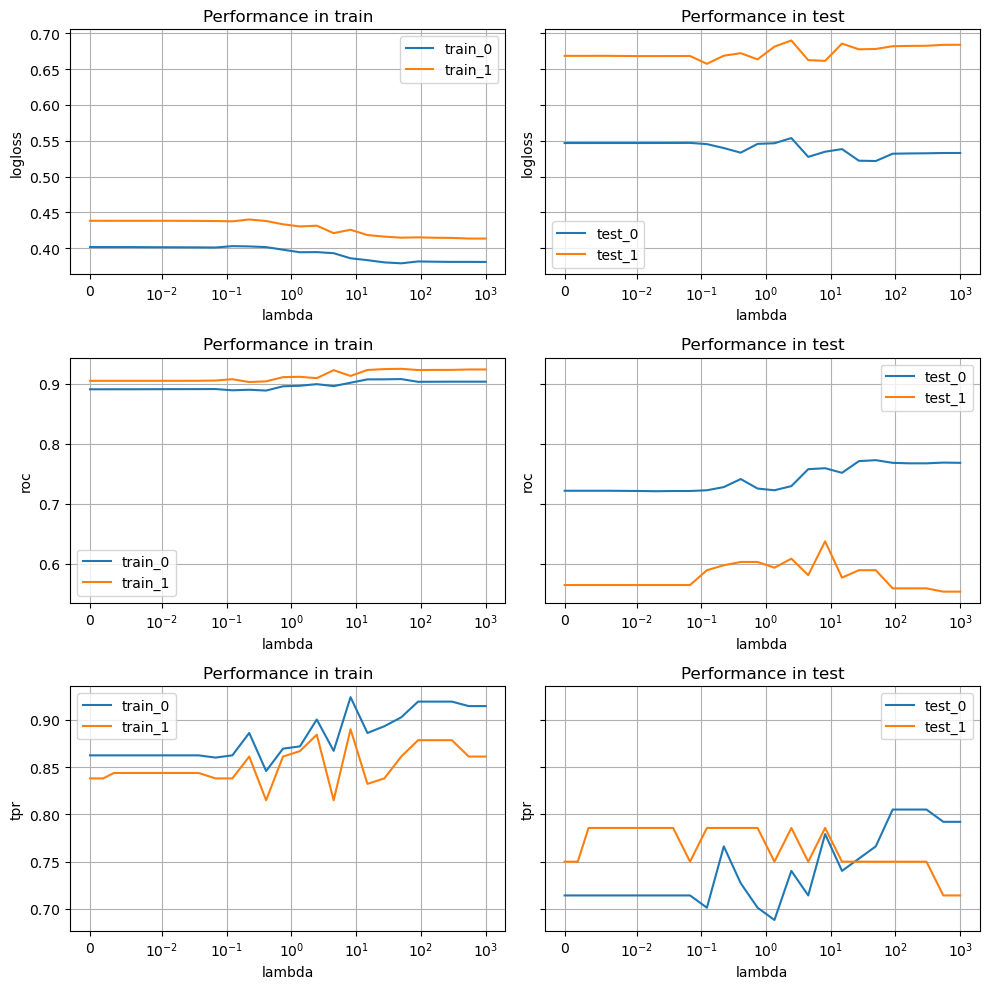

In [54]:
lambda_values = np.append([0],np.logspace(-3, 3, num=24))
results = []
for lambda_value in tqdm(lambda_values):
    cv = GridSearchCV(models.XGBoostWrapper(objective = penalize_max_loss_subgroups(0, lambda_value)), parameters, scoring = "roc_auc")
    cv.fit(X_train, Y_train)
    results_df = utils.eval_model_train_test(
        cv,
        X_train, Y_train, subgroup_train,
        X_test, Y_test, subgroup_test,
    )
    results_df["lambda"] = lambda_value
    results_df["best_params"] = str(cv.best_params_)
    results.append(results_df)
results = pd.concat(results)
utils.comparison_subgrous_metrics_lambda(results)

In [55]:
utils.eval_model_train_test(
    cv,
    X_train, Y_train, subgroup_train,
    X_test, Y_test, subgroup_test,
)

,roc,tpr,fnr,logloss,threshold,accuracy,precision,name
0,0.903231,0.914692,0.085308,0.380827,0.637909,0.872633,0.910377,train_g0
1,0.923561,0.861272,0.138728,0.413441,0.637909,0.847584,0.897590,train_g1
2,0.768060,0.792208,0.207792,0.532965,0.637909,0.733945,0.824324,test_g0
3,0.553571,0.714286,0.285714,0.684066,0.637909,0.585366,0.689655,test_g1
